In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

TEXT_DATA = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

In [ ]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)

    return train_acc, test_acc

In [ ]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange:
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term

    return lb, ub

In [ ]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [ ]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


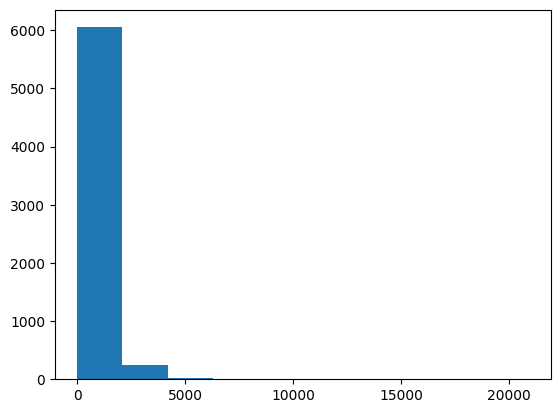

In [ ]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [ ]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word",
                             binary = True,
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names_out())

In [ ]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [ ]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB()

In [ ]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 94.00%
Testing Accuracy: 89.82%


In [ ]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 88.15%-91.48%


In [ ]:
# vectorize the text samples into a 2D integer tensor

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [ ]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data,
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1),
                                                  test_size=TEST_SPLIT)

In [ ]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),

        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=2,
                    validation_data=(x_val, y_val))

Epoch 1/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5705 - loss: 0.6673 - val_accuracy: 0.7624 - val_loss: 0.4986
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8129 - loss: 0.4076 - val_accuracy: 0.9006 - val_loss: 0.2551


In [ ]:
# all possible parameters history stores
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

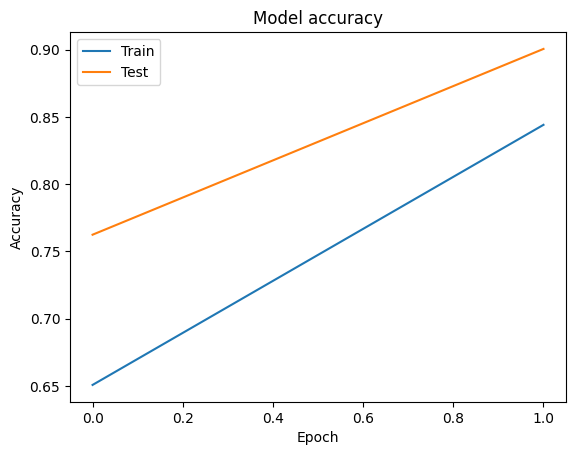

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# evaluate model

train_acc, test_acc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_val,
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Training Accuracy: 92.70%
Testing Accuracy: 90.06%


In [ ]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 88.41%-91.70%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_news(text):

    sequence = tokenizer.texts_to_sequences([text])

    data = pad_sequences(sequence,
                         maxlen=MAX_SEQUENCE_LENGTH,
                         padding='pre',
                         truncating='pre')

    prediction = model.predict(data)

    # Get the single probability value
    probability = prediction[0][0]

    # 4. Interpret the result (based on cell [14])
    print("---" * 15)
    print(f"Article Text: \n\"{text[:250]}...\"") # Print the first 250 characters
    print("\n--- Prediction ---")

    if probability > 0.5:
        print(f"Result: REAL News")
        print(f"Confidence Score: {probability*100:.2f}% (REAL)")
    else:
        print(f"Result: FAKE News")
        print(f"Confidence Score: {(1-probability)*100:.2f}% (FAKE)")

    print(f"(Raw probability: {probability:.6f} -- 0=FAKE, 1=REAL)")
    print("---" * 15 + "\n")


# --- TEST WITH YOUR MANUAL DATA ---

# Example 1: A plausible, neutral news story (likely REAL)
story = ("Trump is now vowing to win enough delegates to clinch the Republican nomination and prevent a contested convention. But Sens.Ted Cruz, R-Texas, Bernie Sanders, D-Vt., and Ohio Gov. John Kasich and aren't giving up just yet.")

predict_news(story)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
---------------------------------------------
Article Text: 
"Trump is now vowing to win enough delegates to clinch the Republican nomination and prevent a contested convention. But Sens.Ted Cruz, R-Texas, Bernie Sanders, D-Vt., and Ohio Gov. John Kasich and aren't giving up just yet...."

--- Prediction ---
Result: REAL News
Confidence Score: 78.61% (REAL)
(Raw probability: 0.786100 -- 0=FAKE, 1=REAL)
---------------------------------------------

